# Landsat_band_analyses_looped.ipynb


This code outputs csv files of statistics for each analysis, as well as plots showing the relative statistical significance of each analysis, for each case study site.

Written by Claire Krause, January 2017, Datacube v 1.13

** Code dependencies **
- csv file containing the bounding boxes for the case study site/s
- palaeovalleys 2012 shape file
- Landsat band average netcdf files produced by "Extract_AGDC_for_study_sites_looped"

**Accompanying code**
- Landsat_band_analyses.ipynb - The accompanying notebook shows what each step in this notebook does, and should be referred to for more detailed explanations. 

In [1]:
# Import the libraries we need in the code and tell matplotlib to display the plots here
%matplotlib inline
import fiona
import shapely.geometry
import rasterio
import rasterio.features
import geopandas as gp
import datacube
datacube.set_options(reproject_threads=1)
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats
import pandas
import csv
import os

In [2]:
# Set up some functions to use later in the code
def warp_geometry(geom, src_crs, dst_crs):
    """
    warp geometry from src_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(src_crs, dst_crs, shapely.geometry.mapping(geom)))

def geometry_mask(geom, geobox, all_touched=False, invert=False):
    """
    rasterize geometry into a binary mask where pixels that overlap geometry are False
    """
    return rasterio.features.geometry_mask([geom],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)
def write_to_csv(OUTPUT_path, row, site):
    if site == 'Blackwood2A':
        with open(OUTPUT_path,'w') as csvFile:
            writer = csv.writer(csvFile)
            header = ['name', 'ttest', 'KS_test']
            writer.writerow(header)
            writer.writerow(row)
    else:
        with open(OUTPUT_path,'a') as csvFile:
           writer = csv.writer(csvFile)
           writer.writerow(row)

## Load in our list of sites

In [3]:
# Set up the case study bounding box (to make the file smaller and avoid memory errors)
# Read in a csv file with all case study bounding boxes
names = pandas.read_csv('/g/data/p25/cek156/case_study_sites_small.csv', delimiter = ',')
print(names)

           Name     minlat     maxlat      minlon      maxlon
0   Blackwood2A -34.100000 -33.400000  116.400000  117.400000
1   Blackwood2B -34.100000 -33.400000  117.400000  118.400000
2   Blackwood2C -33.400000 -32.700000  116.400000  117.400000
3   Blackwood2D -33.400000 -32.700000  117.400000  118.400000
4      GarfordA -29.900000 -29.230000  133.150000  133.925000
5      GarfordB -29.900000 -29.230000  133.925000  134.700000
6     Mandora1A -21.100000 -20.356667  120.900000  121.916667
7     Mandora1B -21.100000 -20.356667  121.916667  122.933333
8     Mandora1C -21.100000 -20.356667  122.933333  123.950000
9     Mandora1D -21.100000 -20.356667  123.950000  124.966667
10    Mandora1E -21.100000 -20.356667  124.966667  125.983333
11    Mandora1F -21.100000 -20.356667  125.983333  127.000000
12    Mandora1G -20.356667 -19.613333  120.900000  121.916667
13    Mandora1H -20.356667 -19.613333  121.916667  122.933333
14    Mandora1I -20.356667 -19.613333  122.933333  123.950000
15    Ma

## Set up the palaeovalley 2012 mask. 
This code reads in the shapefile and identifies and lists all of the polygons witin it. For this example, we are using the 2012 Palaeovalleys shape file (see English et al. 2012)

In [4]:
shp = gp.GeoDataFrame.from_file('/g/data/p25/cek156/Palaeovalleys_2012.shp')
print (shp.head)

<bound method NDFrame.head of                                               geometry
0    POLYGON ((123.648953793 -30.56992565499991, 12...
1    (POLYGON ((117.1778376770001 -32.2709919609999...
2    POLYGON ((115.868565061 -29.73637336599995, 11...
3    POLYGON ((115.948200584 -27.86854227199996, 11...
4    POLYGON ((127.387641593 -28.59592641999996, 12...
5    POLYGON ((128.0569520910001 -28.54635345199995...
6    POLYGON ((128.698006552 -26.21770164599991, 12...
7    POLYGON ((126.722619924 -22.32913755999994, 12...
8    POLYGON ((128.3006654730001 -18.96357787199992...
9    POLYGON ((115.3584853260001 -27.20097888599992...
10   POLYGON ((126.9556900690001 -26.30121716599996...
11   POLYGON ((115.8733712540001 -25.14138591099993...
12   POLYGON ((125.9475394960001 -28.62771558199995...
13   POLYGON ((124.9745967660001 -29.53551659999994...
14   POLYGON ((120.9398331570001 -19.64230130599992...
15   POLYGON ((128.361469574 -22.02882464999993, 12...
16   POLYGON ((123.9446491120001 -3

## Calculate the statistics for each site

Loop through each case study site, calculate a series of band analyses, apply the palaeovalleys 2012 mask, calculate the statistical difference in values inside and outside the masked areas, then write the results to a csv file.

In [5]:
for num, site in enumerate(names.Name):
    print ('Working on ' + site)
    # Set up our file names to be read in
    blue_mean = '/g/data/p25/cek156/' + site + '/' + site + '_blue_time_mean.nc'
    green_mean = '/g/data/p25/cek156/' + site + '/' + site + '_green_time_mean.nc'
    red_mean = '/g/data/p25/cek156/' + site + '/' + site + '_red_time_mean.nc'
    nir_mean = '/g/data/p25/cek156/' + site + '/' + site + '_nir_time_mean.nc'
    swir1_mean = '/g/data/p25/cek156/' + site + '/' + site + '_swir1_time_mean.nc'
    swir2_mean = '/g/data/p25/cek156/' + site + '/' + site + '_swir2_time_mean.nc'
    
    # We need to check that the mean files have been created before we try to read them in
    file_checkb = os.path.isfile(blue_mean)
    file_checkg = os.path.isfile(green_mean)
    file_checkr = os.path.isfile(red_mean)
    file_checkn = os.path.isfile(nir_mean)
    file_checks1 = os.path.isfile(swir1_mean)
    file_checks2 = os.path.isfile(swir2_mean)
    
    # If all the files are then, then we can read them in
    if file_checkb == True & file_checkg == True & file_checkr == True & file_checkn == True & file_checks1 == True & file_checks2 == True:
        blue = xr.open_dataset(blue_mean)
        green = xr.open_dataset(green_mean)
        red = xr.open_dataset(red_mean)
        nir = xr.open_dataset(nir_mean)
        swir1 = xr.open_dataset(swir1_mean) 
        swir2 = xr.open_dataset(swir2_mean)

        ########### Set up the analyses you would like to do ###########################
        # Check out http://www.indexdatabase.de/db/i.php for a list of a whole bunch of indices, 
        # as well as their platform specific formulas (if you click on the index name).
        analyses = {'only_blue':blue.blue,
        'only_green':green.green,
        'only_red':red.red,
        'only_nir':nir.nir,
        'only_swir1':swir1.swir1,
        'only_swir2':swir2.swir2,
        'greenness':(green.green / red.red),
        'drought':(swir2.swir2 / nir.nir),
        'ferrous':(swir1.swir1 / nir.nir),
        'clay':(swir1.swir1 / swir2.swir2),
        'soilBG':(nir.nir - (2.4 * red.red)), # Soil background line
        'soilComp':((swir1.swir1 - nir.nir) / (swir1.swir1 + nir.nir)), # Soil composition index
        'SAVI':(((nir.nir - red.red) / (nir.nir + red.red + 0.5))*(1 + 0.5)), #Soil adjusted vegetation index, where L = 0.5
        'FalseCol':((nir.nir + red.red + green.green)), #False colour
        'RealCol':((red.red + green.green + blue.blue)), #Real colour
        'NDMI':((nir.nir - swir1.swir1) / (nir.nir + swir1.swir1)), #normalised difference moisture index
        'NDSI':((swir1.swir1 - swir2.swir2) / (swir1.swir1 + swir2.swir2))} # normalised difference salinity index
        ################################################################################

        for method in analyses:
            
            data = analyses[method]
            
            OUTPUT = '/g/data/p25/cek156/Landsat/' + method + '_stats.csv'

            # Create a bounding box from the locations specified above
            box = shapely.geometry.box(names.minlon[num], names.minlat[num], names.maxlon[num], names.maxlat[num], ccw = True)
            # Only get the polygons that intersect the bounding box (i.e. remove all the irrelevant ones)
            filtered = shp.where(shp.intersects(box)).dropna()
            # Combine all of the relevant polygons into a single polygon
            shp_union = shapely.ops.unary_union(filtered.geometry)

            # Check for the geobox attribute. If it's not there, apply it from the datacube.
            if not hasattr(data, 'geobox'):
                query = {'time': ('2000-01-01', '2000-01-31'),
                         'lat': (names.maxlat[num], names.minlat[num]), 
                         'lon': (names.minlon[num], names.maxlon[num]), 
                         'resolution': (-250, 250)}
                bands_of_interest = [#'blue',
                                     #'green',
                                     'red', 
                                     #'nir',
                                     #'swir1', 
                                     #'swir2',
                                     ]
                dc = datacube.Datacube(app='hack')
                nbar = dc.load(product = 'ls7_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
                print('Applying datacube geobox')
                geobox = nbar.geobox
            # Create the mask based on our shapefile
            mask = geometry_mask(warp_geometry(shp_union, shp.crs, blue.crs), geobox, invert=True)
            # Get data only where the mask is 'true'
            data_masked = data.where(mask)
            # Get data only where the mask is 'false'
            data_maskedF = data.where(~ mask)

            ## Now check for statistical significance
            # Create a new numpy array with just the slope values
            data_masked2 = np.array(data_masked)
            data_maskedF2 = np.array(data_maskedF)
            # Remove nan values
            data_masked_nonan = data_masked2[~np.isnan(data_masked2)]
            data_maskedF_nonan = data_maskedF2[~np.isnan(data_maskedF2)]
            masked_both = [data_masked_nonan,data_maskedF_nonan]
            if data_masked_nonan.any():
                # How many data points are in each of my NDVI lists?
                size = ([len(i) for i in masked_both])
                # Test with a t-test
                stats_ttest, ttest_pval = scipy.stats.ttest_ind(data_masked_nonan,data_maskedF_nonan, equal_var = 'False')
                # Test with a Kolmogorov-Smirnov test 
                # Our null hypothesis that 2 independent samples are drawn from the same continuous distribution
                stats_KS, KS_pval = scipy.stats.ks_2samp(data_masked_nonan,data_maskedF_nonan)

                # Write to csv file
                row = [site, stats_ttest, stats_KS]
                # Write our stats to a csv file so we can compare them later
                # If this is the first site, make a new file, otherwise, append the existing file
                print('writing to csv')
                write_to_csv(OUTPUT, row, site)
                # Or if there is no data...
            else:
                print('no useful data')
                row = [site, 'nan', 'nan']
                write_to_csv(OUTPUT, row, site)
        # Or if there is no data...
    else:
        print('No mean files yet for' + site)

Working on Blackwood2A
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Working on Blackwood2B
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing to csv
Applying datacube geobox
writing t

ValueError: Input is not a valid geometry object

## Read in the csv files and prepare for plotting

At this stage, the smaller chunks of each case study area still have their own statistics. We want to know what the solution is over the whole bounding box, so we will average the stats together here to give us just one output for each site.

Working on drought
Working on RealCol
Working on FalseCol
Working on only_swir2
Working on NDMI
Working on clay
Working on only_blue
Working on soilComp
Working on ferrous
Working on greenness
Working on only_green
Working on NDSI
Working on soilBG
Working on only_nir
Working on only_swir1
Working on SAVI
Working on only_red


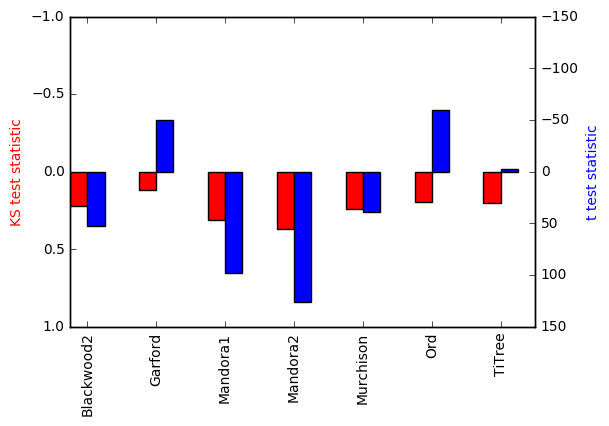

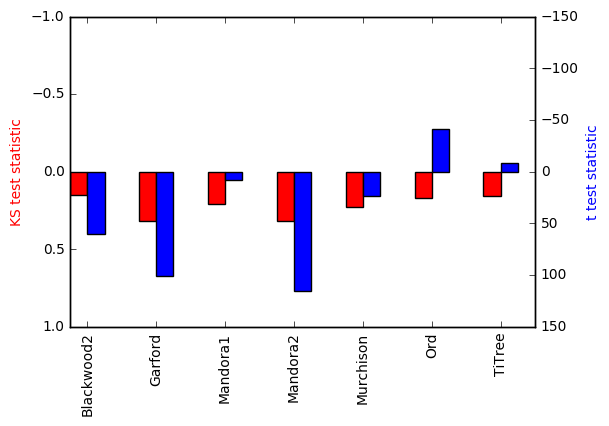

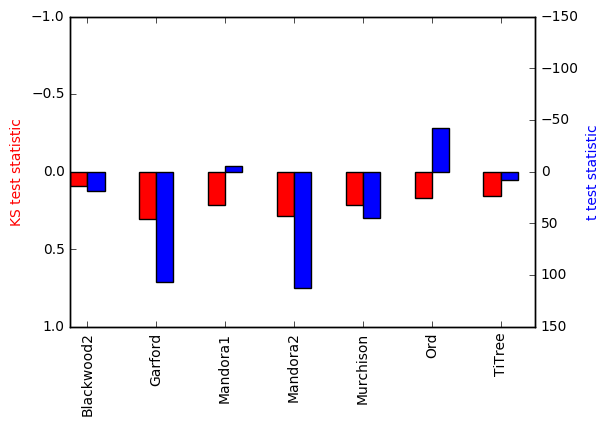

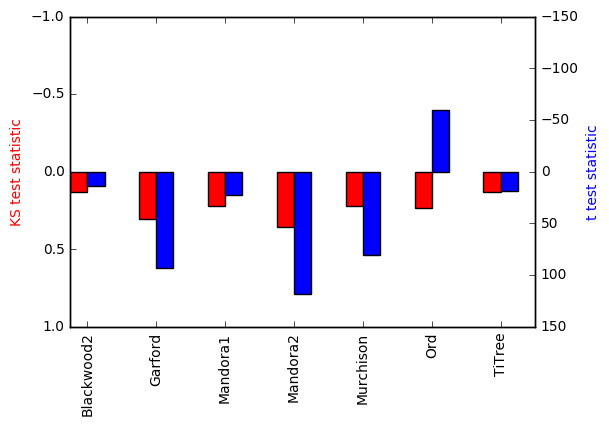

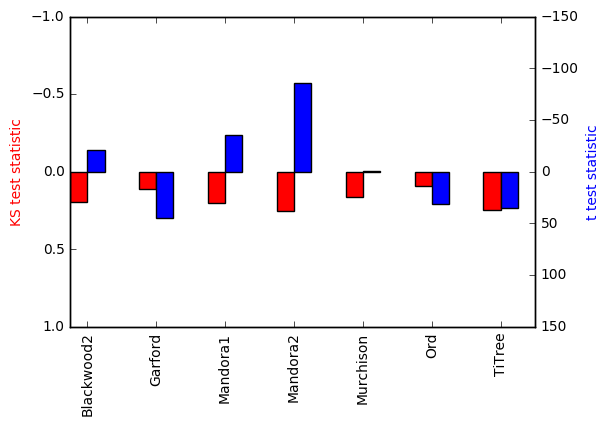

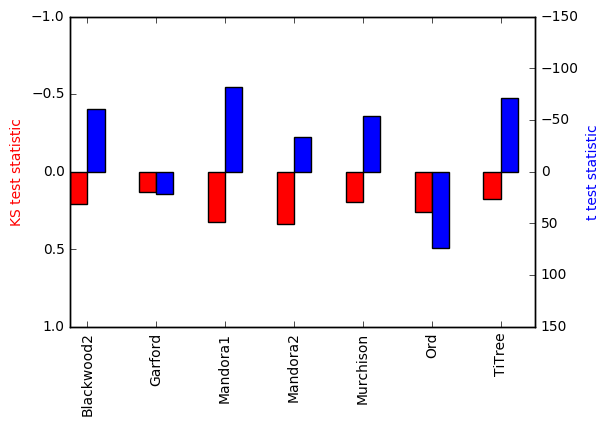

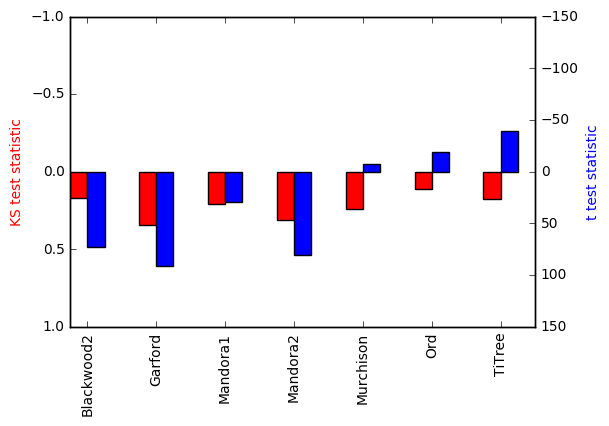

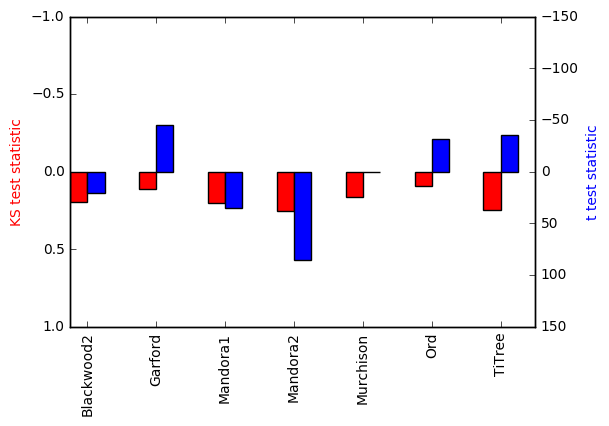

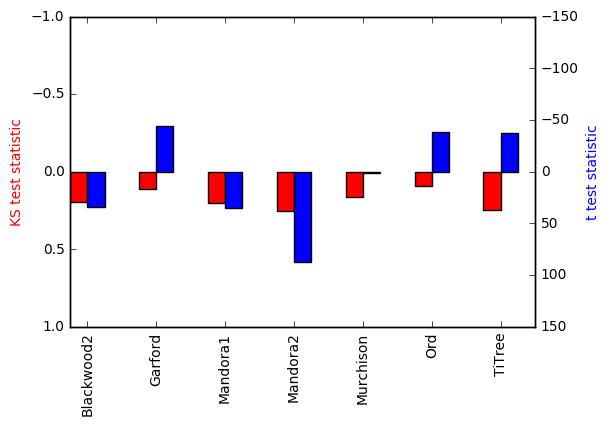

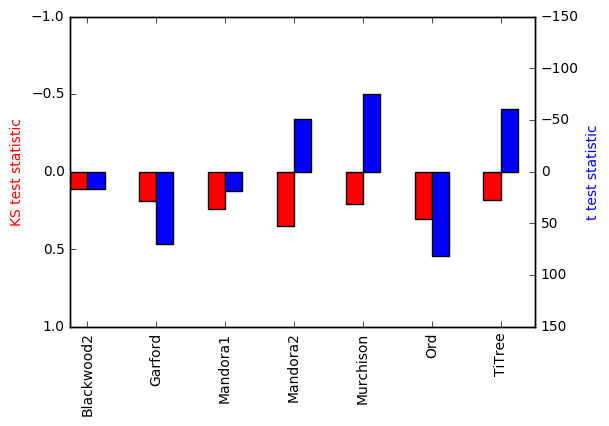

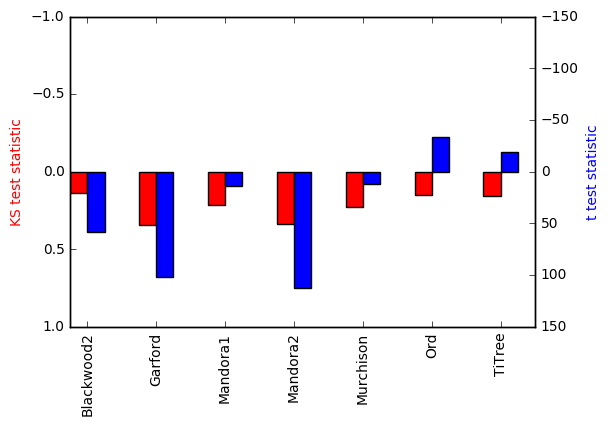

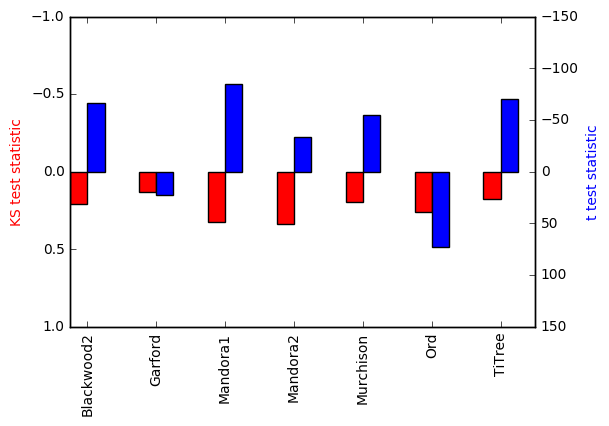

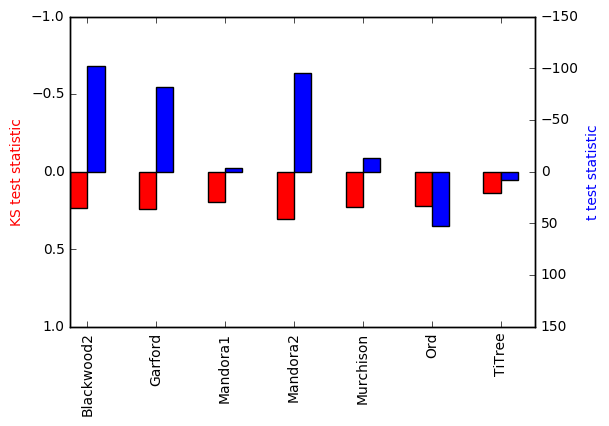

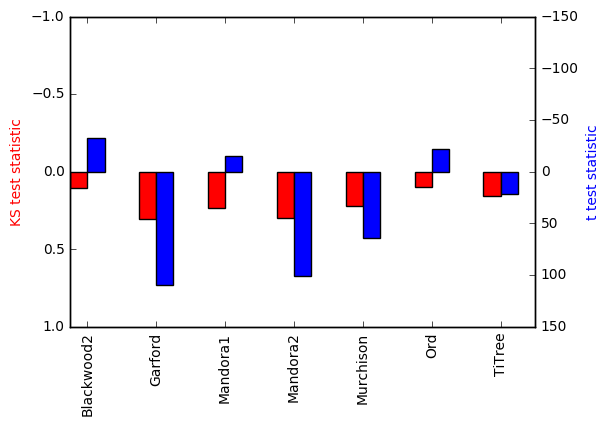

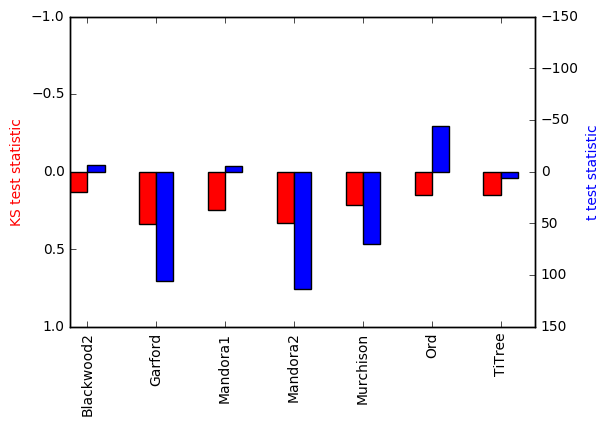

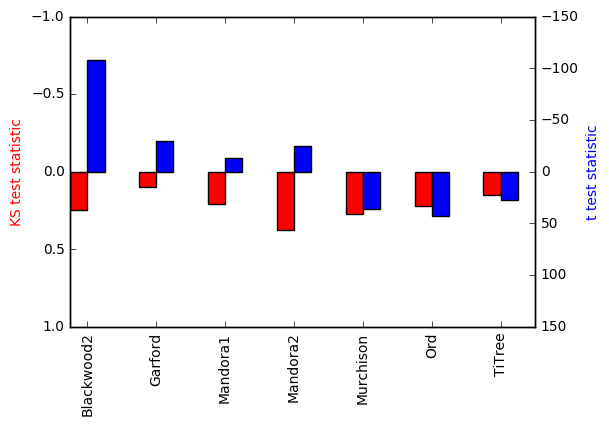

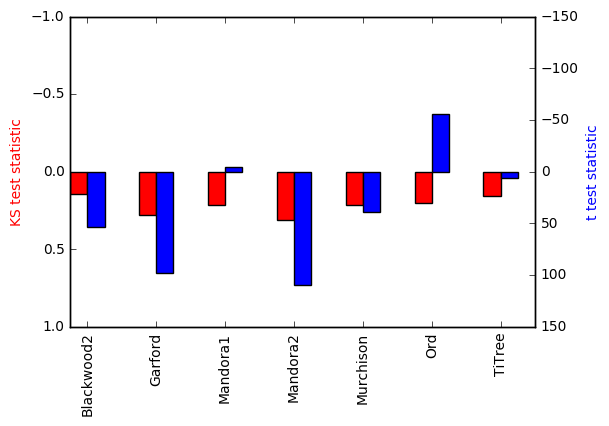

In [6]:
study_sites = pandas.read_csv('/g/data/p25/cek156/case_study_sites.csv')

for method in analyses:
    #Read in the CSVs
    OUTPUT = '/g/data/p25/cek156/Landsat/' + method + '_stats.csv'
    print('Working on ' + method)
    method_stats = pandas.read_csv(OUTPUT)

    mean_values = pandas.DataFrame(columns = ['Site', 'ttest_mean', 'KS_mean'])

    exclude_last_three = study_sites[:-3]
    for idx, site in enumerate(exclude_last_three.Name):
        ttest_mean = method_stats[method_stats.name.str.contains(site)].ttest.mean()
        ks_mean = method_stats[method_stats.name.str.contains(site)].KS_test.mean()
        mean_values.loc[idx] = [site, ttest_mean, ks_mean]

    # Setting the positions and width for the bars
    pos = list(range(len(mean_values.ttest_mean)))
    width = 0.25

    fig = plt.figure()
    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

    mean_values.KS_mean.plot(kind='bar', color='red', ax=ax, width=width, position=1)
    mean_values.ttest_mean.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

    # Set the y axis label
    ax.set_ylabel('KS test statistic', color='red')
    ax2.set_ylabel('t test statistic', color='blue')

    # Set the labels for the x ticks
    ax.set_xticklabels(mean_values['Site'])

    # Setting the x-axis and y-axis limits
    ax2.set_ylim([150, -150])
    ax.set_ylim([1, -1])

    #Let's save the plot
    fig.savefig('/g/data/p25/cek156/Landsat/' + method + '_stats.jpg', bbox_inches='tight')